In [4]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import time
#Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding,Bidirectional, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

In [5]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

## Mounting from gDrive

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
foldername = "/content/drive/MyDrive/Shopee Code League -Address Elements Extraction/"

## Retrieving Data

In [8]:
#Read csv
trainPath = foldername+"train.csv"
testPath = foldername+"test.csv"
train = pd.read_csv (trainPath)
test = pd.read_csv (testPath)

In [9]:
df_train = pd.DataFrame(train, columns= ['id','raw_address','POI/street'])
print(df_train)

            id  ...                                 POI/street
0            0  ...  /jl kapuk timur delta sili iii lippo cika
1            1  ...                                          /
2            2  ...                                     /siung
3            3  ...                                 toko dita/
4            4  ...                             /jl. orde baru
...        ...  ...                                        ...
299995  299995  ...                           /jend ahmad yani
299996  299996  ...                             /raya cila kko
299997  299997  ...                                          /
299998  299998  ...                                taman asri/
299999  299999  ...                      jaya maspion permata/

[300000 rows x 3 columns]


In [10]:
df_test = pd.DataFrame(test, columns= ['id','raw_address'])
print(df_test)

          id                                        raw_address
0          0              s. par 53 sidanegara 4 cilacap tengah
1          1              angg per, baloi indah kel. lubuk baja
2          2                              asma laun, mand imog,
3          3      ud agung rej, raya nga sri wedari karanganyar
4          4                         cut mutia, 35 baiturrahman
...      ...                                                ...
49995  49995                    toko mbak farid semboro semboro
49996  49996     vie - tk. ridho kids, vete 3 cari, 16720 ciawi
49997  49997                mart dan roti bakar malabar, nasio,
49998  49998  graha indah pamulang jl. mujair raya bambu apu...
49999  49999                                               adi,

[50000 rows x 2 columns]


In [11]:
#Call all the raw addresses
df_train.raw_address

0         jl kapuk timur delta sili iii lippo cika 11 a ...
1                                        aye, jati sampurna
2                      setu siung 119 rt 5 1 13880 cipayung
3                                      toko dita, kertosono
4                                             jl. orde baru
                                ...                        
299995                 jend ahmad yani 331 kertasari ciamis
299996                   raya cila kko, cilandak timur kel.
299997                       tanjung gusta jl. yaya 2 no 17
299998    jalan cipadu jaya taman asri gang bijaksana 3 ...
299999            jaya maspion permata blok beryl b2  no.58
Name: raw_address, Length: 300000, dtype: object

In [12]:
#Get a rows of addresses
df_train.loc[2:6]

,id,raw_address,POI/street
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung
3,3,"toko dita, kertosono",toko dita/
4,4,jl. orde baru,/jl. orde baru
5,5,"raya samb gede, 299 toko bb kids",toko bb kids/raya samb gede
6,6,"kem mel raya, no 4 bojong rawalumbu rt 1 36 ra...",/kem mel raya


In [13]:
df_train.raw_address.shape

(300000,)

In [14]:
splitedAddress = df_train['POI/street'].apply(lambda x: x.split('/'))
df_train['POI'] = splitedAddress.apply(lambda x: x[0])
df_train['street'] = splitedAddress.apply(lambda x: x[1])

In [15]:
df_train = pd.DataFrame(df_train, columns= ['id','raw_address','POI','street'])

In [16]:
df_train

,id,raw_address,POI,street
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,,jl kapuk timur delta sili iii lippo cika
1,1,"aye, jati sampurna",,
2,2,setu siung 119 rt 5 1 13880 cipayung,,siung
3,3,"toko dita, kertosono",toko dita,
4,4,jl. orde baru,,jl. orde baru
...,...,...,...,...
299995,299995,jend ahmad yani 331 kertasari ciamis,,jend ahmad yani
299996,299996,"raya cila kko, cilandak timur kel.",,raya cila kko
299997,299997,tanjung gusta jl. yaya 2 no 17,,
299998,299998,jalan cipadu jaya taman asri gang bijaksana 3 ...,taman asri,


## Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


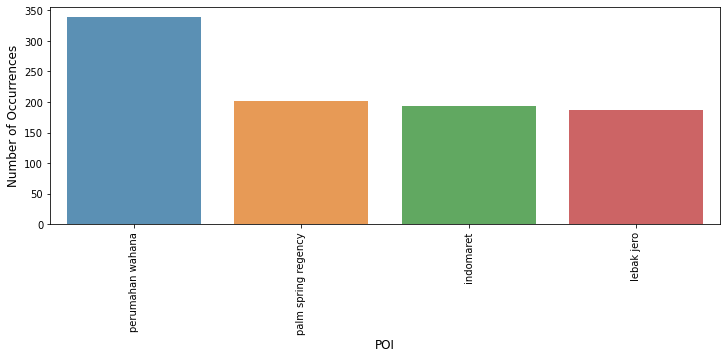

In [17]:
#Display POI
cnt_pro = df_train['POI'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro[1:5].index, cnt_pro[1:5].values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('POI', fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Tokenization

In [18]:
def tokenize(contents):
  allAddresses = contents
  tokens = []
  for address in allAddresses:
    words = address.split()
    for word in words:
      tokens.append(word.lower())
  return tokens

In [19]:
#Get Tokens
trainX_tokens = tokenize(df_train.raw_address)
trainY1_tokens = tokenize(df_train.POI)
trainY2_tokens = tokenize(df_train.street)

In [20]:
#Number of tokens found
print("raw address: ",len(trainX_tokens))
print("POI: ",len(trainY1_tokens))
print("street: ",len(trainY2_tokens))

raw address:  2052655
POI:  343135
street:  514871


In [21]:
# number of UNIQUE tokens found
print("raw address: ",len(set(trainX_tokens)))
print("POI: ",len(set(trainY1_tokens)))
print("street: ",len(set(trainY2_tokens)))

vocabulary = set(trainX_tokens)
vocab_size = len(vocabulary)

raw address:  121318
POI:  53246
street:  23866


In [22]:
frequency_dist = nltk.FreqDist(trainX_tokens)
#Show top 50 tokens
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:5]

['no', 'rt', 'raya', '1', 'rw']

## Set Up the Model

In [23]:
raws = df_train['raw_address']
pois = df_train['POI']

In [24]:
# TOKENIZE TEXT SEQUENCE
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['raw_address'].values)

In [25]:
X = tokenizer.texts_to_sequences(df_train['raw_address'].values)
X = pad_sequences(X)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (300000, 33)


In [26]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

81787


In [27]:
Y = tokenizer.texts_to_sequences(df_train['POI'].values)
Y = pad_sequences(Y, maxlen=X.shape[1])

print('Shape of data tensor:', Y.shape)

Shape of data tensor: (300000, 33)


In [38]:
streets = tokenizer.texts_to_sequences(df_train['street'].values)
streets = pad_sequences(Y, maxlen=X.shape[1])

print('Shape of data tensor:', streets.shape)

Shape of data tensor: (300000, 33)


In [37]:
print("X: ",X.shape)
print("Y: ",Y.shape)
print("Y_street: ",streets.shape)

X:  (300000, 33)
Y:  (300000, 33)
Y_street:  (300000, 33)


In [30]:
print("Raw address: ",raws[5])
print(X[5])
print("POI: ",pois[5])
print(Y[5])

Raw address:  raya samb gede, 299 toko bb kids
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    3 3221
  128 7032   23 3222 2181]
POI:  toko bb kids
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   23 3222 2181]


In [31]:
#Variables
RANDOM_STATE = 50
#EPOCHS = 10
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 0
SAVE_MODEL = True
# OUTPUT DIMENSION OF THE EMBEDDING LAYER
EM_OUTPUT_LENGTH = 50

In [32]:
# GET THE SEQUENCE LENGTH
seq_length = X.shape[1]
seq_length

33

In [33]:
# Fit Model function
def fit_model(model_name, batch_size, X, y, epochs):
    model = Sequential()
    model.add(Embedding(vocab_size, EM_OUTPUT_LENGTH))
    model.add(LSTM(150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dense(vocab_size/2, activation='relu'))
    model.add(Dense(seq_length, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    # save the weights for different configuration
    filepath = f"{model_name}-LSTM-{epochs}_epoch-{batch_size}_batch_size"
    filepath = foldername+"Model/"+filepath

    csv_logger = CSVLogger(filepath+".csv",append=False,separator=',')
    checkpoint = ModelCheckpoint(filepath+".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=1, min_lr=1e-8)
    early_stopping = EarlyStopping(monitor='loss',
                                    mode='min',
                                    verbose=1,
                                    patience=50)
    desired_callbacks = [checkpoint, early_stopping, csv_logger, reduce_lr]
    start = time.perf_counter()
    model.fit(X, y, 
              batch_size = batch_size, 
              epochs = epochs)
    time_taken = time.perf_counter() - start
    print(f"Total time taken for {epochs} epochs: {time_taken} seconds")
    print(f"Average time taken per epochs: {time_taken/epochs} seconds")
    print(f"Total time taken to train: {time_taken} seconds")

    return model

In [34]:
# LOAD PRE-TRAINED H5 FILES
# Write a function to load different variant of the pre-trained model
def load_pretrain_model(model_name,batch_size,epochs, optimizer_type):
    filepath = f"{model_name}-LSTM-{epochs}_epoch-{batch_size}_batch_size.h5"
    filepath = foldername+"Model/"+filepath
    # load the model
    model = load_model(filepath)
    #model.summary()

    return model

In [35]:
poi_model = fit_model(model_name="POI",batch_size=BATCH_SIZE, X=X, y=Y, epochs=EPOCHS)

Epoch 1/150
147/147 [==============================] - 17s 95ms/step - loss: 1894223.4485 - accuracy: 0.2003
Epoch 2/150
147/147 [==============================] - 14s 94ms/step - loss: 17237488.8986 - accuracy: 0.2062
Epoch 3/150
147/147 [==============================] - 14s 94ms/step - loss: 43075019.9865 - accuracy: 0.2068
Epoch 4/150
147/147 [==============================] - 14s 94ms/step - loss: 87887479.8649 - accuracy: 0.2073
Epoch 5/150
147/147 [==============================] - 14s 94ms/step - loss: 127773312.3784 - accuracy: 0.2059
Epoch 6/150
147/147 [==============================] - 14s 94ms/step - loss: 192973005.6216 - accuracy: 0.2063
Epoch 7/150
147/147 [==============================] - 14s 94ms/step - loss: 251996266.9189 - accuracy: 0.2065
Epoch 8/150
147/147 [==============================] - 14s 94ms/step - loss: 331703480.4324 - accuracy: 0.2062
Epoch 9/150
147/147 [==============================] - 14s 94ms/step - loss: 403001708.7568 - accuracy: 0.2078
Epoch 

In [ ]:
street_model = fit_model(model_name="street",batch_size=BATCH_SIZE, X=X, y=streets, epochs=EPOCHS)

Epoch 1/150
147/147 [==============================] - 16s 94ms/step - loss: 1464959.4096 - accuracy: 0.2000
Epoch 2/150
147/147 [==============================] - 14s 93ms/step - loss: 14050516.4122 - accuracy: 0.2066
Epoch 3/150
147/147 [==============================] - 14s 94ms/step - loss: 37503283.9595 - accuracy: 0.2057
Epoch 4/150
147/147 [==============================] - 14s 94ms/step - loss: 75334454.8649 - accuracy: 0.2058
Epoch 5/150
147/147 [==============================] - 14s 93ms/step - loss: 127899496.4324 - accuracy: 0.2055
Epoch 6/150
147/147 [==============================] - 14s 94ms/step - loss: 190503535.8919 - accuracy: 0.2069
Epoch 7/150
147/147 [==============================] - 14s 94ms/step - loss: 262243828.2162 - accuracy: 0.2074
Epoch 8/150
147/147 [==============================] - 14s 93ms/step - loss: 316054577.5135 - accuracy: 0.2062
Epoch 9/150
147/147 [==============================] - 14s 94ms/step - loss: 406230647.7838 - accuracy: 0.2076
Epoch 